## Optimal transport formulations

Let $x = \sum_{i=0}^{n} \delta_{x_i}$ and $y = \sum_{i=0}^{n} \delta_{y_i}$ be two discrete measures

**Monge formulation**

the Monge formulation of the optimal transport problem is

<font color="blue">
$$ \begin{array}{c}\text{min}\\ \sigma \in \Pi_{N}\end{array}
\left\{ \sum_{i=1}^{N} C_{i},\sigma(i) \right\}$$
</font>

where
- $\Pi_{N}$: set of all the permutation matrices of $\{1, \ldots, N\} \text{x} \{1, \ldots, N\}$
- $\sigma \in \Pi_{N}$: permutation matrix
- $\sigma(i)$: ith row of $\sigma$.

**Kantorovich formulation**

<font color="blue">
$$M \in \textbf{B}_{N} = \left\{ P \in \mathbb{R}^{N\text{x}N}_{+} : \sum_{i}P_{i,j}=1 \, \sum_{j}P_{i,j}=1 \right\}$$
</font>

where
- $\textbf{B}_{N}$: set of all the bistochastic matrices in $R^{N\text{x}N}$

### Sinkhorn theorem

There exist diagonal matrices $U$ and $V$ such that $P = U M V$ is bistochastic matrix

### Birkhoff-von-Neumann decomposition

The Birkhoff-von-Neumann decomposition of a bistochastic matrix $P \in \mathbf{B}_N$ is 

$$
P = \sum_{i=0}^{m} \lambda_i Pi
$$

where $\lambda_i \in [0, 1]$ and $P_i \in \Pi_n$ is a permutation matrix

## From Kantorovich to Monge

### Importing libraries

In [1]:
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
plt.style.use("science")
from scipy.optimize import linprog

**Discrete measures**

In [2]:
N = 6
x = np.array([24., 9., 3., 16., 21., 27.])
y = np.array([3., 23., 18., 26., 16., 14.])

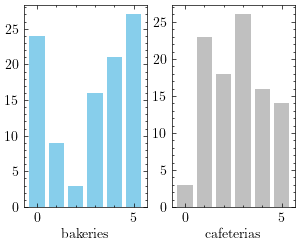

In [3]:
fig, axes = plt.subplots(1, 2);
axes[0].bar(range(N), x, color = "skyblue")
axes[0].set_xlabel("bakeries")
axes[1].bar(range(N), y, color = "silver")
axes[1].set_xlabel("cafeterias")
plt.show()

**Cost matrix**

In [4]:
c = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        c[i,j] = np.abs(x[i] - y[j])

In [5]:
c

array([[21.,  1.,  6.,  2.,  8., 10.],
       [ 6., 14.,  9., 17.,  7.,  5.],
       [ 0., 20., 15., 23., 13., 11.],
       [13.,  7.,  2., 10.,  0.,  2.],
       [18.,  2.,  3.,  5.,  5.,  7.],
       [24.,  4.,  9.,  1., 11., 13.]])

**Solving the problem**

The optimal transport problem can be solved by the an integer linear program 

<font color="blue">
$$
\begin{align}
\text{min} \big\{ <c, z> : p \geq 0, Az = b\big\}
\end{align}
$$
</font>

where c is the vectorized cost matrix C, z is the vectorized matrix Z,
 $A = \left[
\begin{array}{c}
I_{N} \otimes 1_{1\text{x}N}\\
1_{1\text{x}N} \otimes I_{N}
\end{array}
\right]$
and $b=\left[\begin{array}{c}x\\ y \end{array}\right]$

In [6]:
def solv_lp(x, y, N, c):
    Ax = np.kron(np.identity(N), np.ones(N))
    Ay = np.kron(np.ones(N), np.identity(N))
    A = np.concatenate((Ax, Ay), 0)
    b = np.concatenate((x, y))
    res = linprog(c, A_eq = A, b_eq = b, method = 'highs')
    z = res.x
    Z = z.reshape((N, N))
    return Z

In [7]:
z = solv_lp(x, y, N, c.reshape(N*N))
z.shape

(6, 6)

In [8]:
z

array([[ 0., 23.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  9.],
       [ 3.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 15.,  1.],
       [ 0.,  0., 18.,  0.,  0.,  3.],
       [ 0.,  0.,  0., 26.,  1.,  0.]])

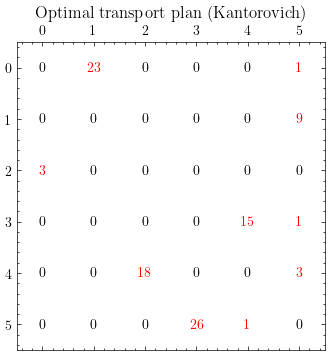

In [9]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.matshow(c, cmap = mpl.colors.ListedColormap(["white"]))
ax.set_title("Optimal transport plan (Kantorovich)")
for i in range(N):
    for j in range(N):
        color = 'red' if z[i,j] > 0 else 'black'
        ax.text(j, i, int(z[i, j]), horizontalalignment = 'center',
                verticalalignment = 'center', weight = 'bold', color = color)

**Sinkhorn algorithm**

In [10]:
def sinkhorn_algorithm(z, N, itermax = 1000, eps = 1e-1):
    u = np.ones(N)
    u0 = u.copy()
    v = np.ones(N)
    v0 = v.copy()
    for i in range(itermax):
        v = np.ones(N) / (z.T @ u)
        u = np.ones(N) / (z @ v)
        if np.linalg.norm(u - u0) < eps and np.linalg.norm(v - v0) < eps:
            print("Sinkhorn algorithm converged after {} iterations".format(i))
            break
        else:
            u0 = u.copy()
            v0 = v.copy()
    return u,v

In [11]:
u, v = sinkhorn_algorithm(z, N)

The matrix $P = Diag(u) M Diag(v)$

In [12]:
P = np.diag(u) @ z @ np.diag(v)

We can check that P is indeed a bistochastic matrix

In [13]:
P.sum(0)

array([1.        , 0.99988094, 0.9998426 , 0.99915164, 1.00010294,
       1.00102188])

In [14]:
P.sum(1)

array([1., 1., 1., 1., 1., 1.])

**From Monge to Kantorovich**

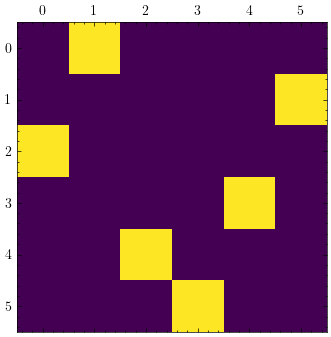

In [15]:
plt.matshow(P)
plt.show()

In [16]:
Q = np.zeros((N, N))
Q[P > 0.1] = 1.

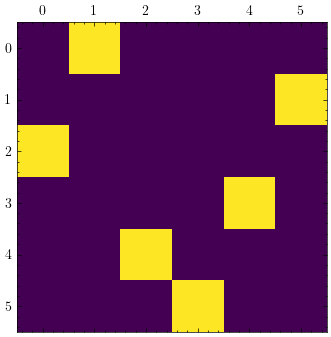

In [17]:
plt.matshow(Q)
plt.show()

**Solution to the Monge formulation**

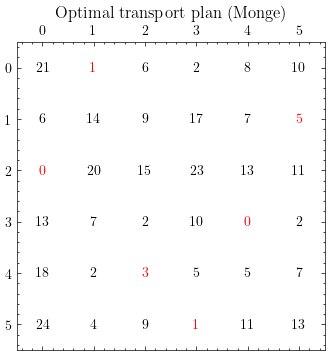

In [18]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.matshow(c, cmap = mpl.colors.ListedColormap(["white"]))
ax.set_title("Optimal transport plan (Monge)")
for i in range(N):
    for j in range(N):
        if (Q[i,j] > 0):
            color = 'red'
        else:
            color = 'black'
        ax.text(j, i, int(c[i, j]), horizontalalignment = 'center',
                verticalalignment = 'center', weight = 'bold', color = color)